# Задача 1

Оцените скорость сходимости среднего по выборке из логнормального распределения к нормальному распределению (как предписывает ЦПТ) в зависимости от:

1. Размера выборки
2. Параметров логнормального распределения


In [51]:
import numpy as np
from scipy import stats
from scipy.stats import kstest
import matplotlib.pyplot as plt
import functools
import seaborn as sns
from scipy import stats
import matplotlib.cm as cm

In [2]:
def decorator(func):
    @functools.wraps(func)
    def wrapper():
        return func().upper()
    return wrapper

In [49]:
def normalised_lognorm(mu, sigma, n, m):
    mean_lgn = np.exp(mu+ 0.5 * sigma**2)
    sigma_lgn = np.sqrt((np.exp(sigma**2) - 1)*np.exp(2*mu + sigma**2))
    s = np.random.lognormal(mu, sigma, (n,m)) # выборка размером m,  n семплов
    s_normalised =  np.sqrt(m)*(s.mean(axis = 1) - mean_lgn)/sigma_lgn
    
    return s_normalised, kstest(s_normalised,'norm').statistic  # просто супремум разности, нормального и цпт от логнормального

Если оценивать скорость сходимости по распределению в смысле супремума 
разности  между эмпирической функцией распределения величин $$\sqrt{n} \cdot \frac{\overline{X_n} - \mu}{\sigma} $$, и функцией распределения нормальной случайной величины, то необхдоимо вариировать не только n - размер выборки по которой берём среднее, но и количество семплов, иначе сходится не будем. Если увеличивать только размер семплов для заданного n, то не соблюдаем ЦПТ, если увеличивать только n, оставляя одинаковым количество сэмплов, то нарушаем критерий Колмогорова. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


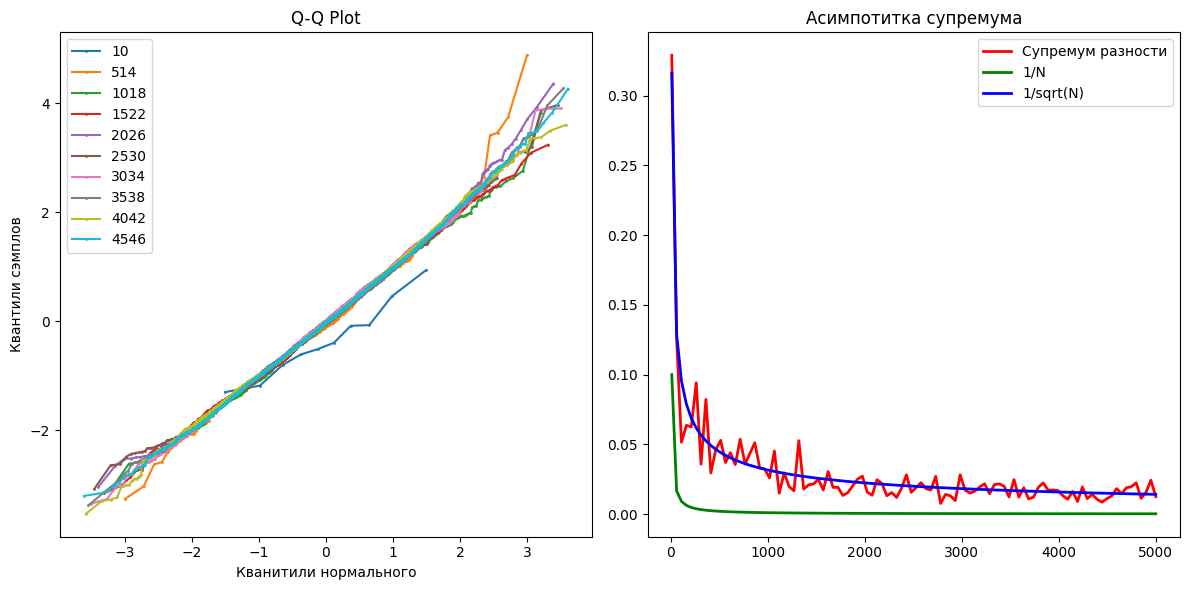

In [79]:
stat_list = []
N = np.linspace(10,5000,100,dtype="int")
set_for_qq_plot = set(N[::10])
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
for n in N:
    norm_s, supremum = normalised_lognorm(0,1,n,n)
    if n in  set_for_qq_plot:
        res = stats.probplot(norm_s, dist="norm")
        ax[0].plot(res[0][0], res[0][1],markersize=1, marker =  'o', label=f'{n}' )
    stat_list.append(supremum)
ax[0].set_title("Q-Q Plot")
ax[0].set_xlabel("Кванитили нормального")
ax[0].set_ylabel("Квантили сэмплов")
ax[0].legend()
ax[1].set_title("Асимпотитка супремума")
ax[1].legend()
ax[1].plot(N, stat_list, linewidth=2, color='r')
ax[1].plot(N, 1/N, linewidth=2, color='g')
ax[1].plot(N, 1/np.sqrt(N), linewidth=2, color='b')
ax[1].legend(["Супремум разности", "1/N", "1/sqrt(N)" , "1/log N" ])
plt.tight_layout()
plt.show()

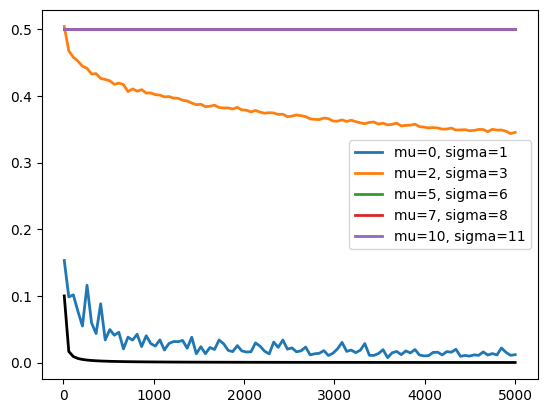

In [66]:
N = np.linspace(10,5000,100,dtype="int")
mu = np.linspace(0, 10, 5,dtype="int")
sigma = np.linspace(1,11, 5,dtype="int")
for m_v,sgima_v  in  list(zip(mu,sigma)):
    stat_list = []
    for n in N:
        _, supremun = normalised_lognorm(m_v,sgima_v, n,n)
        stat_list.append(supremun)
    plt.plot(N, stat_list, linewidth=2, label=f"mu={m_v}, sigma={sgima_v}")
plt.plot(N, 1/N, linewidth=2, color='black')
plt.legend()

# Отображаем график
plt.show()

# Задача 2

Возьмите [данные](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-cosmetics-shop) с Kaggle и оцените равномерность разбиения их на группы (для будущего АБ-теста) с помощью различных видов хеширования:

1. md5
2. sha256
3. Улучшится ли равномерность, если вместо одинарного использования md5 применить [вот такую](https://towardsdatascience.com/assign-experiment-variants-at-scale-in-a-b-tests-e80fedb2779d) двухуровневую процедуру с тем же md5, проверить на тех же данных

In [7]:
import hashlib as hl
import math

In [8]:
import pandas as pd
import glob

path = "./hw2_data"  
csv_files = glob.glob(f"{path}/*.csv")
df_list = [pd.read_csv(file) for file in csv_files]
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [9]:
combined_df.shape

(20692840, 9)

In [10]:
df = combined_df.drop_duplicates(subset='user_id', keep='first')

In [11]:
df.shape

(1639358, 9)

In [12]:
df['user_id'].nunique()

1639358

In [13]:
def proxy(hash_func, salt, n_groups,boosted):
    def wrapper(uid):
        if boosted== False:
            return int(hash_func((str(uid) + salt).encode()).hexdigest(), 16) % n_groups 
        return math.floor(int(hash_func((str(uid) + salt).encode()).hexdigest(), 16)*10000/float(0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF)) %n_groups 
    return wrapper

In [14]:
md5_hash = proxy(hl.md5, "salt" ,100, False)

In [15]:
df.loc[:, "id_group_md5"] = df["user_id"].apply(md5_hash)

C:\Users\kuzin\AppData\Local\Temp\ipykernel_19092\3143252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "id_group_md5"] = df["user_id"].apply(md5_hash)


In [16]:
df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,id_group_md5
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,59
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,17


In [17]:
df_md5 = df.groupby("id_group_md5").size()
ax = df_md5.plot(kind='bar', x='id_group_md5', y='count')
ax.set_xticklabels([])
plt.show()

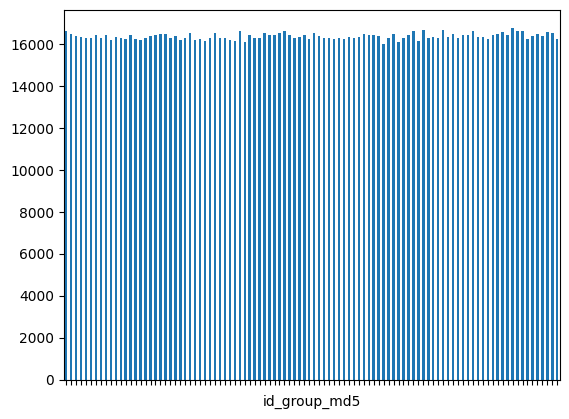

In [18]:
ax = df_md5.plot(kind='bar', x='id_group_md5', y='count')
ax.set_xticklabels([])
plt.show()

C:\Users\kuzin\AppData\Local\Temp\ipykernel_19092\2452981903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "id_group_sha256"] = df["user_id"].apply(sha256_hash)


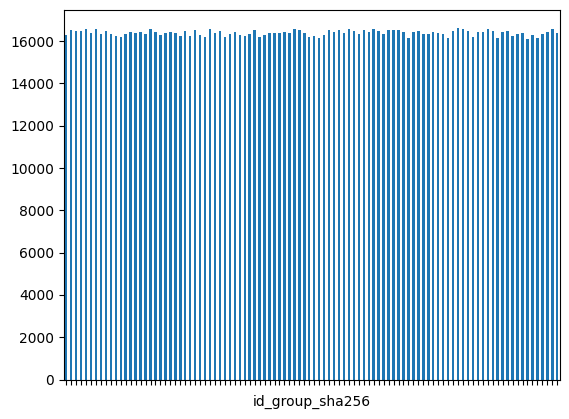

In [19]:
sha256_hash = proxy(hl.sha256, "salt" ,100, False)
df.loc[:, "id_group_sha256"] = df["user_id"].apply(sha256_hash)
df_sha256 = df.groupby("id_group_sha256").size()
ax = df_sha256.plot(kind='bar', x='id_group_sha256', y='count')
ax.set_xticklabels([])
plt.show()

In [20]:
md5_hash_boosted = proxy(hl.md5, "salt" ,100, True)

In [21]:
df.loc[:, "id_group_md5_boosted"] = df["user_id"].apply(md5_hash_boosted)

C:\Users\kuzin\AppData\Local\Temp\ipykernel_19092\34448339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "id_group_md5_boosted"] = df["user_id"].apply(md5_hash_boosted)


In [22]:
df.head(2)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,id_group_md5,id_group_sha256,id_group_md5_boosted
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,59,60,11
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,17,0,48


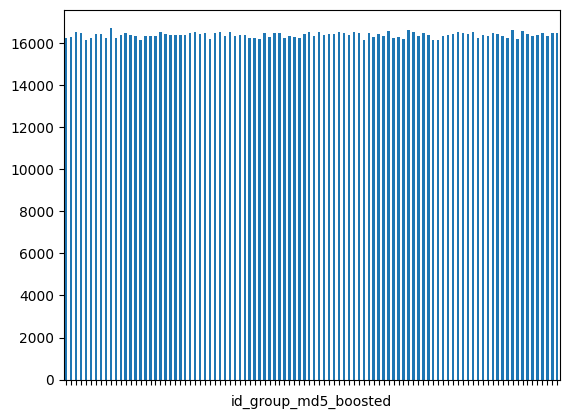

In [23]:
df_md5_boosted = df.groupby("id_group_md5_boosted").size()
ax = df_md5_boosted.plot(kind='bar', x='id_group_sha256', y='count')
ax.set_xticklabels([])
plt.show()

In [24]:
diff_md_5  = df_md5.max() - df_md5.min()
diff_md_5_boosted  = df_md5_boosted.max() - df_md5_boosted.min()
diff_md_5 , diff_md_5_boosted 

(790, 606)

In [25]:
df_md5.describe()

count      100.000000
mean     16393.580000
std        145.607066
min      16016.000000
25%      16291.750000
50%      16377.000000
75%      16481.000000
max      16806.000000
dtype: float64

In [26]:
df_md5_boosted.describe()

count      100.00000
mean     16393.58000
std        122.96671
min      16137.00000
25%      16314.00000
50%      16406.00000
75%      16488.50000
max      16743.00000
dtype: float64

# Задача 3

Напишите функцию для оценки доверительного интервала для параметра в выборке с помощью Пуассоновского бутстрепа.
Функция должна принимать на вход выборку и агрегационную функцию, с помощью которой будет вычисляться статистика по выборке, например:

    PoissonBootstrap(sample, np.median)
    
или
    
    PoissonBootstrap(sample, lambda x: np.median(x)/np.mean(x))
    
    

In [31]:
def PoissonBootstrap(data, agg_func, n_iter = 1000, alpha =  0.05):

    point_estimation  = agg_func(data)
    data = np.array(data)
    n = len(data)

    weights = np.random.poisson(1, (n_iter, n)) # Пуассоним

    statistics_over_samples = []

    for weight in weights:
        resampled_data = np.repeat(data, weight) # семпл
        statistics_over_samples.append(agg_func(resampled_data))
        
    #Перцентильный доверительный интервал
    left, right = np.quantile(statistics_over_samples, [alpha / 2, 1 - alpha / 2])
    return left, right, statistics_over_samples  

-0.09880765973680669 0.06260517566602462


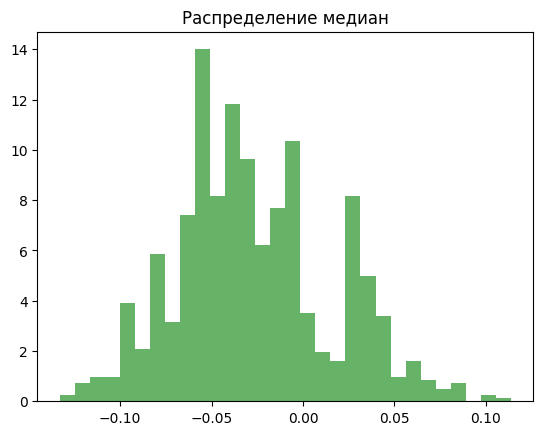

In [32]:
data = np.random.normal(0, 1, 1000)
lb, rb,statistics =  PoissonBootstrap(data, np.median)   
print(lb, rb)
plt.hist(statistics, bins=30, density=True, alpha=0.6, color='g')
plt.title("Распределение медиан")
plt.show()

# Задача 4

C помощью численного эксперимента показать, что t-тест над рангами в некотором смысле эквивалентен тесту Манна-Уитни.
В качестве пояснения можете использовать материал [Линделёва](https://lindeloev.github.io/tests-as-linear/)

Результаты t-теста над рангами: t-статистика = -1.0717, p-значение = 0.2839
Результаты теста Манна-Уитни: U-статистика = 49562484.0000, p-значение = 0.2839


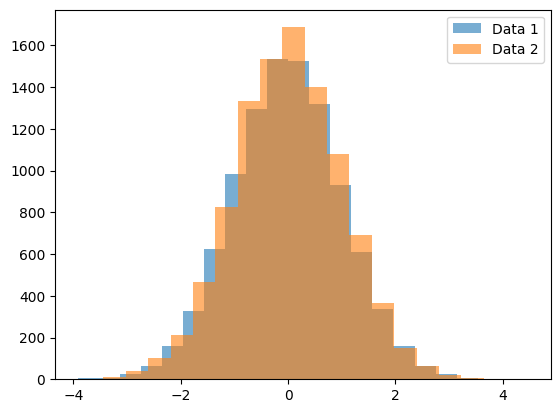

In [43]:
np.random.seed(42) 
n = 10000
data1 = np.random.normal(loc=0, scale=1, size=n)
data2 = np.random.normal(loc=0, scale=1, size=n)


data_combined = np.concatenate([data1, data2])
ranks = stats.rankdata(data_combined)

ranks1 = ranks[:n]
ranks2 = ranks[n:]

t_stat, p_value_t_ranks = stats.ttest_ind(ranks1, ranks2)

u_stat, p_value_mw = stats.mannwhitneyu(data1, data2, alternative='two-sided')


print(f"Результаты t-теста над рангами: t-статистика = {t_stat:.4f}, p-значение = {p_value_t_ranks:.4f}")
print(f"Результаты теста Манна-Уитни: U-статистика = {u_stat:.4f}, p-значение = {p_value_mw:.4f}")

plt.hist(data1, bins=20, alpha=0.6, label='Data 1')
plt.hist(data2, bins=20, alpha=0.6, label='Data 2')
plt.legend()
plt.show()